In [1]:
## Use the pism-ens-analysis functions to aggregate simple measures
## that say something of the Antarctic equilibrium states of a certain 
## ensemble.

In [2]:
%matplotlib inline
%config InlineBackend.figure_formats = {'png',}

In [3]:
#plt.style.use('classic')
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = 12,8
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['font.size'] = 12
plt.rcParams['xtick.major.pad'] = 10
plt.rcParams['font.sans-serif'] = [u"Liberation Sans"] + plt.rcParams['font.sans-serif']
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['axes.xmargin'] =  0.05  
plt.rcParams['axes.ymargin'] =  0.05 

In [4]:
import os, sys
import glob
from matplotlib import cm
import netCDF4 as nc
import collections
import dimarray as da
import itertools
import numpy as np
import pandas

# our custom imports
if "../" not in sys.path: sys.path.append("../")
import config as cf; reload(cf)
# addpath = os.path.abspath("../pism_ens_analysis")
# sys.path.append(os.path.abspath("../pism_ens_analysis"))
import pism_ens_analysis.timeseries as ts; reload(ts)
import pism_ens_analysis.pism_ens_analysis as ea; reload(ea)

<module 'pism_ens_analysis.pism_ens_analysis' from '../pism_ens_analysis/pism_ens_analysis.pyc'>

In [5]:
# get the ensemble members and the corresepondingtimeseries data.
ensemble_members = sorted(glob.glob(os.path.join(
    cf.working_dir,cf.ensemble_name)+"_*"))
ts_data = ts.get_timeseries_data2(ensemble_members)

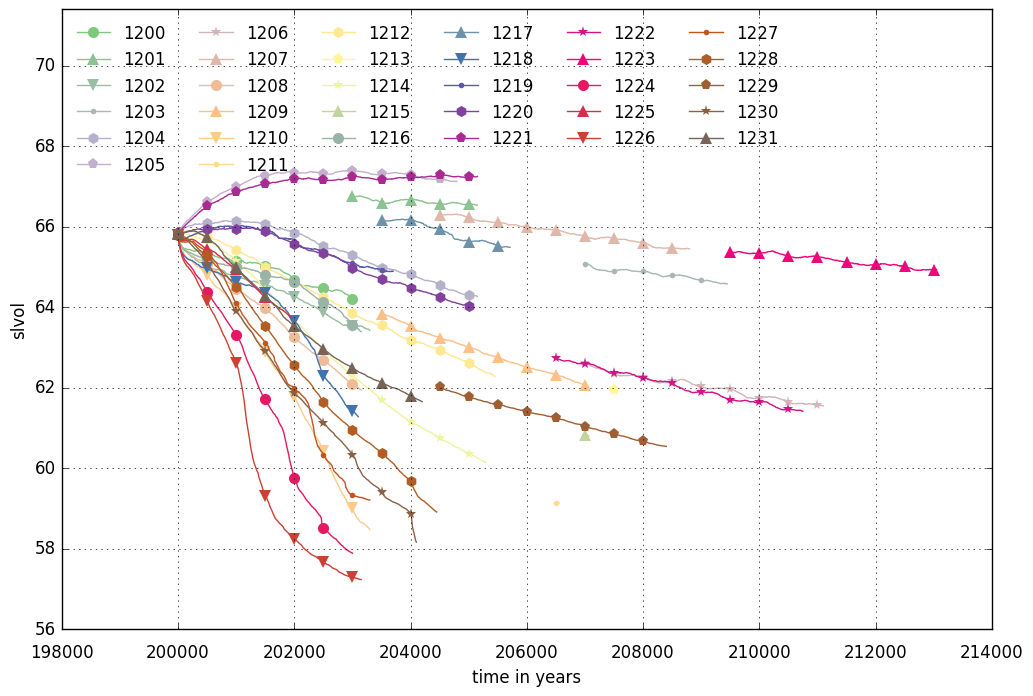

In [6]:
## First simple check: timeseries variables like slvol
## We do not expect them to stay close to their initial value, but it would 
## be good if they do not escape too far (and maybe come back close).

ts_variable = "slvol"

cols = [cm.Accent(np.float(k) / len(ts_data))
            for k in np.arange(len(ts_data))]
marker = itertools.cycle(('o', '^', 'v', '.',"h","p","*","^"))

for i,em in enumerate(ts_data):
    
    tsd = ts_data[em]
    plt.plot(tsd.time,tsd[ts_variable], label=em.split("km_")[-1],
            color=cols[i], marker=marker.next(),markevery=500,markeredgewidth=0)

plt.ylabel(ts_variable)
plt.xlabel("time in years")
l1 = plt.legend(ncol=6,loc="upper left")
l1.draw_frame(0)
plt.grid()
ylims = plt.ylim(plt.ylim()[0],plt.ylim()[1]*1.05)

In [7]:
# Find last common time. This is just an indicator, it is not 
# always useful to limit analysis to the shortest run in the ensemble.
last_common_time, longest_runtime = ts.get_last_common_time(ts_data)
print "We may analyze all ensemble members up to year", last_common_time

We may analyze all ensemble members up to year 201951


In [8]:
# make sure that snapshots or extra files exist for analysis_year.
analysis_year = 208000
# select the runs that are included in the score analysis
long_runs = [run for run in ts_data.keys() if ts_data[run].time[-1] > analysis_year]
long_runs = [os.path.join(cf.working_dir,run) for run in long_runs]

In [9]:
long_runs

['/p/tmp/mengel/pism_out/pismpik_036_initmip08km_1203',
 '/p/tmp/mengel/pism_out/pismpik_036_initmip08km_1206',
 '/p/tmp/mengel/pism_out/pismpik_036_initmip08km_1207',
 '/p/tmp/mengel/pism_out/pismpik_036_initmip08km_1222',
 '/p/tmp/mengel/pism_out/pismpik_036_initmip08km_1223',
 '/p/tmp/mengel/pism_out/pismpik_036_initmip08km_1229']

In [10]:
# Example of collections scores.

varnames_for_rms = ["usurf","thk"]

refncr = nc.Dataset(os.path.join(ensemble_members[0],
                     "snapshots_100000.000.nc"),"r")

scores = ea.collect_scores(long_runs, analysis_year, varnames_for_rms,
                           refncr)
refncr.close()

pismpik_036_initmip08km_1203 pismpik_036_initmip08km_1206 pismpik_036_initmip08km_1207 pismpik_036_initmip08km_1222 pismpik_036_initmip08km_1223 pismpik_036_initmip08km_1229


In [11]:
# Example for getting one score.

one_score = collections.OrderedDict()

refncr = nc.Dataset(os.path.join(ensemble_members[0],
                     "snapshots_100000.000.nc"),"r")
for em in long_runs:
    run = em.split("/")[-1]
    print run,

    ncr = nc.Dataset(os.path.join(em,"extra_"+str(analysis_year)+".000.nc"),"r")
    one_score[run] = collections.OrderedDict()
    one_score[run] = ea.get_wais_ungrounded_area(one_score[run] , ncr, refncr)
    ncr.close()
refncr.close()

pismpik_036_initmip08km_1203 pismpik_036_initmip08km_1206 pismpik_036_initmip08km_1207 pismpik_036_initmip08km_1222 pismpik_036_initmip08km_1223 pismpik_036_initmip08km_1229


In [12]:

run_ids = [np.int(nm.split("km_")[-1]) for nm in scores.keys()]
score_arrays = ea.collect_scores_to_arrays(scores)
score_arrays_norm = ea.normalize_scores(score_arrays)

In [13]:
score_arrays_norm.keys()

['rms_usurf',
 'rms_usurf_floating',
 'rms_usurf_grounded',
 'rms_thk',
 'rms_thk_floating',
 'rms_thk_grounded',
 'floating_in_obs_now_not',
 'floating_now_not_in_obs',
 'grounded_in_obs_now_not',
 'grounded_now_not_in_obs',
 'wais_ungrounded']

In [14]:
scores_to_use = ['rms_usurf_grounded','rms_thk_floating',
                 'floating_now_not_in_obs','grounded_now_not_in_obs',
                 'wais_ungrounded']

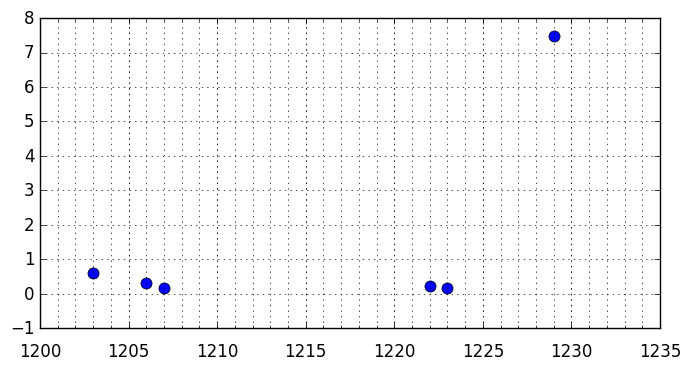

In [15]:
# Create a total score by multiplication of the single scores. And plot.
# You may set a manual ylimit, as some scores are really far out.

total_score = np.ones_like(score_arrays_norm[score_arrays_norm.keys()[0]])

for mn in scores_to_use:
    total_score *= score_arrays_norm[mn]

plt.figure(figsize=(8,4))

plt.plot(run_ids, total_score,"o")
# plt.ylim(0,1)

ax = plt.gca()
minor_ticks = np.arange(plt.xlim()[0],plt.xlim()[1]+1,1)
ax.set_xticks(minor_ticks, minor=True)
ax.xaxis.grid(which='minor')

plt.grid()

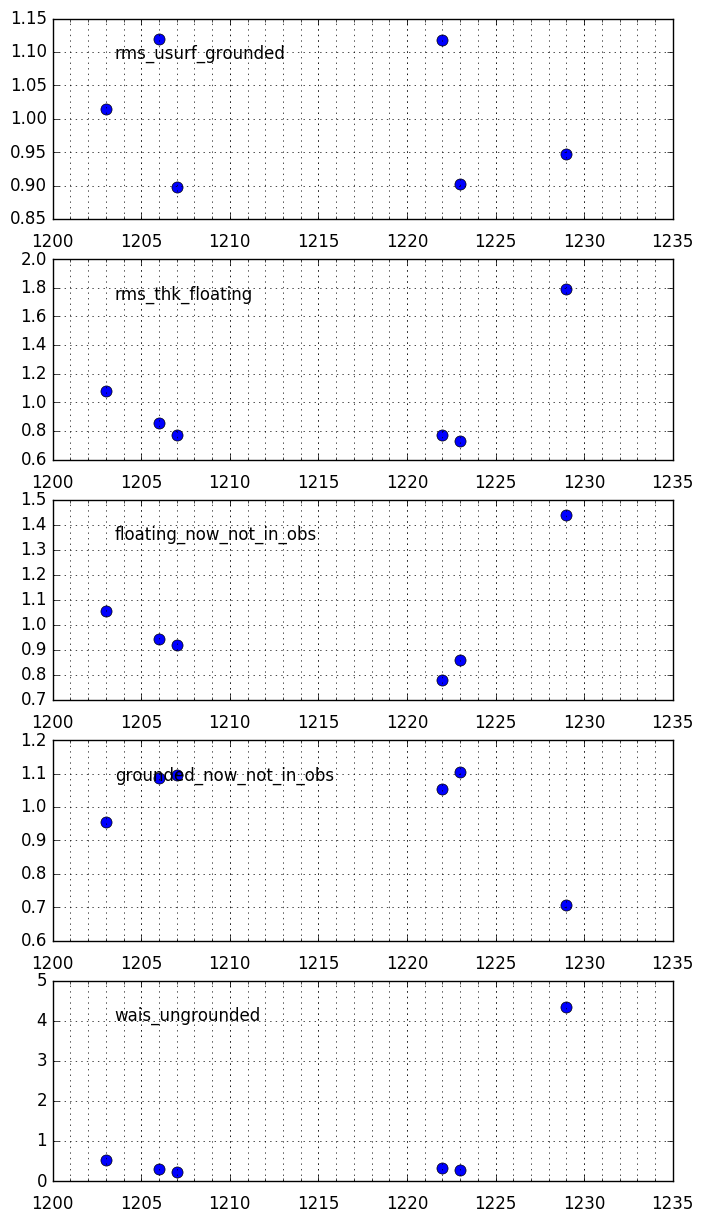

In [16]:
# Plot the single scores

plt.figure(figsize=(8,15))
axs = [plt.subplot(len(scores_to_use),1,i+1) for i in range(len(scores_to_use))]

for i,mn in enumerate(scores_to_use):
    measure = score_arrays_norm[mn]
    axs[i].plot(run_ids, measure,"o")
    minor_ticks = np.arange(axs[i].get_xlim()[0],axs[i].get_xlim()[1]+1,1)
    axs[i].set_xticks(minor_ticks, minor=True)
    axs[i].xaxis.grid(which='minor')
    axs[i].grid()
    axs[i].text(0.1,0.8, mn ,transform=axs[i].transAxes)

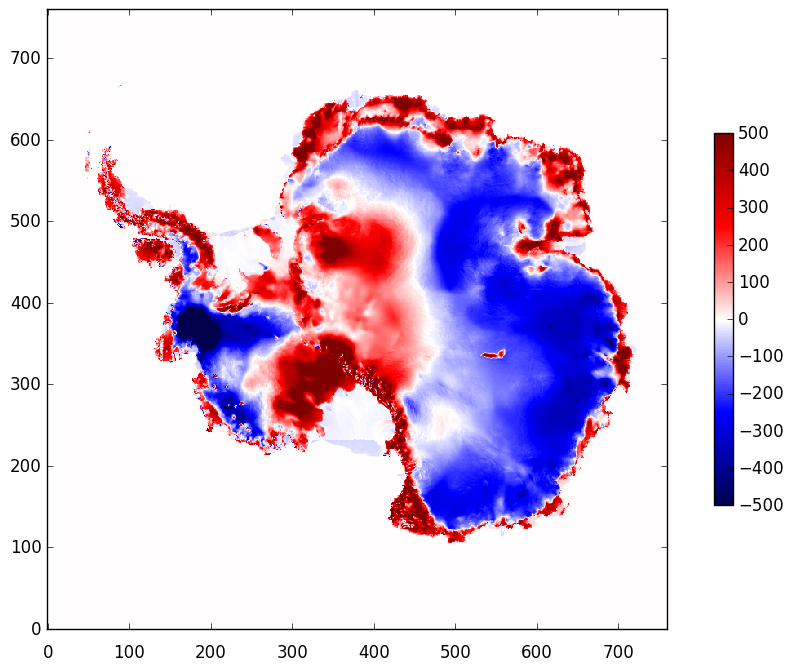

In [17]:
# Example for plotting a field of a single run against a reference.
# A bit unrelated, but good for checks.

varname = "usurf"
variable = ea.get_spatial_variable(os.path.join(ensemble_members[3],
                              "extra_"+str(analysis_year)+".000.nc"), varname)

# very first snapshot from smoothing run
refvariable = ea.get_spatial_variable(os.path.join(ensemble_members[3],
                                 "snapshots_100000.000.nc"), varname)

plt.imshow(variable-refvariable,interpolation="nearest",origin="lower", cmap=cm.seismic,
          vmin=-500,vmax=500)
plt.colorbar(shrink=0.6)